# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [75]:
import tensorflow as tf
import os

In [76]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [77]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [2]:
import cv2
import imghdr

In [16]:
data_dir = './HandPD Dataset/data/' 

In [17]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [18]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [19]:
import numpy as np
from matplotlib import pyplot as plt

In [40]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
print(data)

Found 66 files belonging to 2 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [41]:
data_iterator = data.as_numpy_iterator()

In [42]:
batch = data_iterator.next()

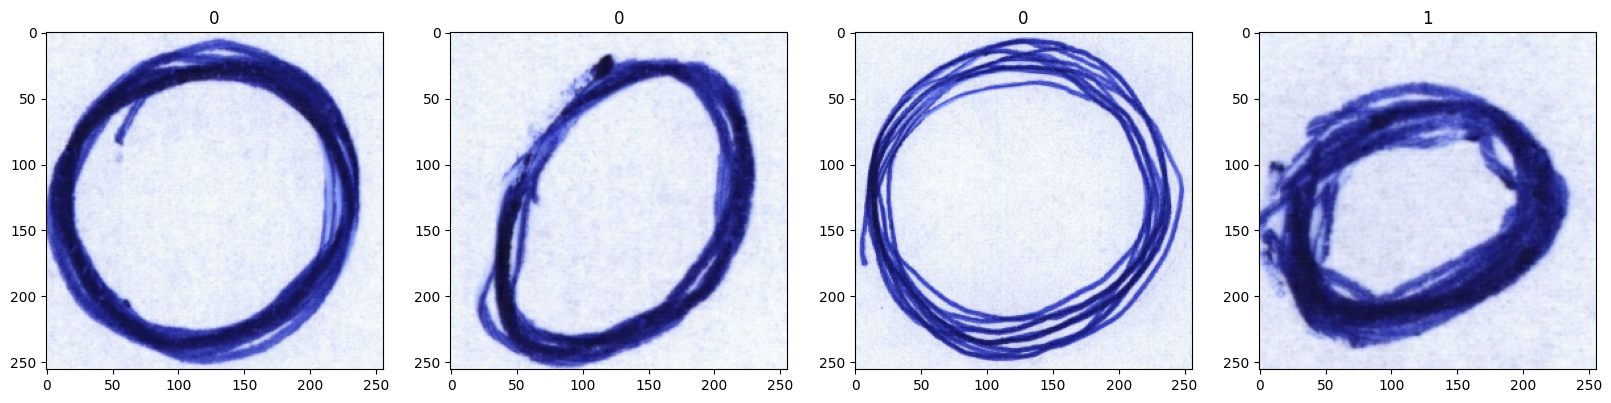

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [44]:
data = data.map(lambda x,y: (x/255, y))

In [45]:
data.as_numpy_iterator().next()

(array([[[[0.9490196 , 0.9647059 , 1.        ],
          [0.9436275 , 0.95931375, 0.9973039 ],
          [0.9348039 , 0.9504902 , 0.99289215],
          ...,
          [0.92009807, 0.94754905, 0.9789216 ],
          [0.9112745 , 0.9387255 , 0.970098  ],
          [0.90588236, 0.93333334, 0.9647059 ]],
 
         [[0.91267616, 0.9283624 , 0.9720435 ],
          [0.9197771 , 0.9373853 , 0.9808795 ],
          [0.9313967 , 0.9521501 , 0.9953383 ],
          ...,
          [0.9208843 , 0.9483353 , 0.97970784],
          [0.91677845, 0.9442294 , 0.975602  ],
          [0.9142693 , 0.9417203 , 0.97309285]],
 
         [[0.883724  , 0.9035003 , 0.9546492 ],
          [0.8881235 , 0.91059595, 0.9603968 ],
          [0.8953228 , 0.922207  , 0.96980196],
          ...,
          [0.9369861 , 0.95830196, 0.98986626],
          [0.93132925, 0.9526451 , 0.9853597 ],
          [0.92787224, 0.9491881 , 0.9826057 ]],
 
         ...,
 
         [[0.87025124, 0.90554535, 0.9643689 ],
          [0.87294

# 5. Split Data

In [46]:
train_size = int(len(data)*.9)
val_size = int(len(data)*0)
test_size = int(len(data)*.1)

In [47]:
train_size

2

In [50]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


# 6. Build Deep Learning Model

In [51]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [53]:
model = Sequential()

In [54]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [55]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [57]:
logdir='logs'

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
2/2 [==============================] - 7s 2s/step - loss: 0.8970 - accuracy: 0.4844
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 0.7006 - accuracy: 0.5469
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 0.6826 - accuracy: 0.5156
Epoch 4/20
2/2 [==============================] - 4s 2s/step - loss: 0.6504 - accuracy: 0.6562
Epoch 5/20
2/2 [==============================] - 4s 2s/step - loss: 0.5577 - accuracy: 0.7344
Epoch 6/20
2/2 [==============================] - 4s 2s/step - loss: 0.5079 - accuracy: 0.6719
Epoch 7/20
2/2 [==============================] - 4s 2s/step - loss: 0.4119 - accuracy: 0.8281
Epoch 8/20
2/2 [==============================] - 4s 2s/step - loss: 0.3806 - accuracy: 0.8281
Epoch 9/20
2/2 [==============================] - 3s 1s/step - loss: 0.3122 - accuracy: 0.8906
Epoch 10/20
2/2 [==============================] - 4s 2s/step - loss: 0.3622 - accuracy: 0.8281
Epoch 11/20
2/2 [==============================] 

# 8. Plot Performance

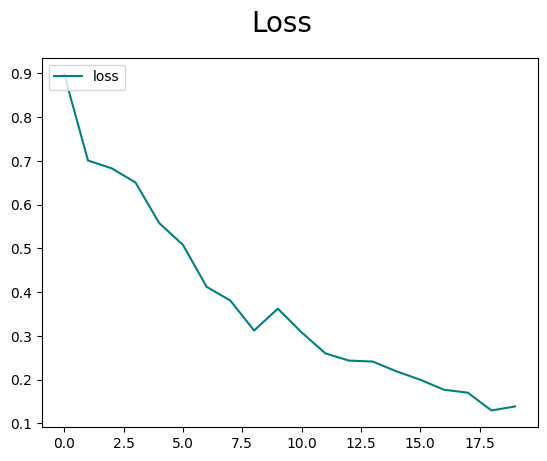

In [61]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
# plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

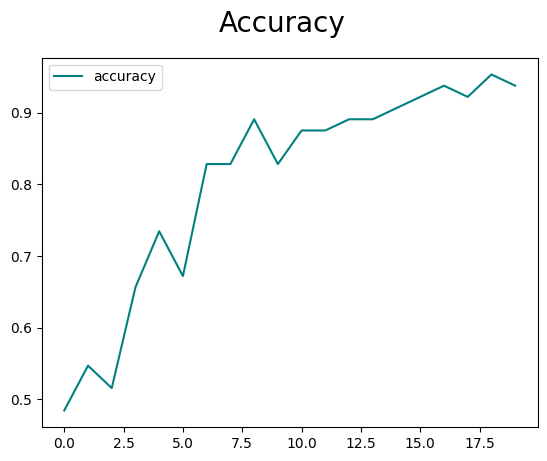

In [63]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
# plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [64]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [65]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [66]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [67]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [68]:
import cv2

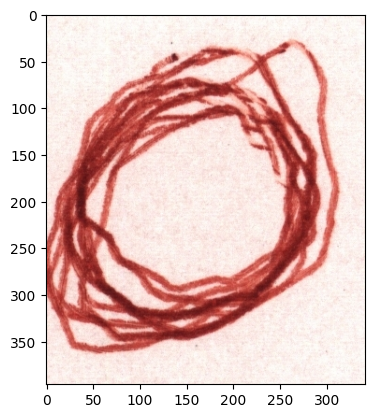

In [70]:
img = cv2.imread('./HandPD Dataset/test_pd.jpg')
plt.imshow(img)
plt.show()

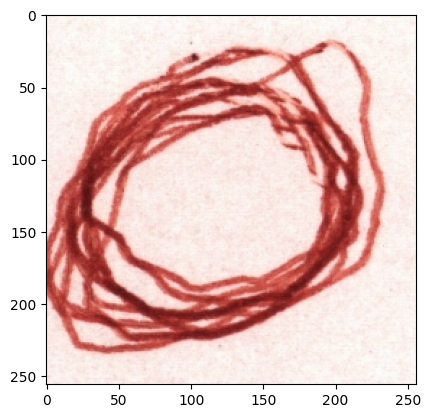

In [71]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [72]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 223ms/step


In [73]:
yhat

array([[0.8901568]], dtype=float32)

In [74]:
if yhat > 0.5: 
    print(f'Circle of Patient with Parkinsons')
else:
    print(f'Circle of Patient in control group')

Circle of Patient with Parkinsons


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)